# AnnoyClassifier

## Importing Packages

In [1]:
from mlots import AnnoyClassifier
from sklearn.model_selection import GridSearchCV
from scipy.io import arff
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from sklearn.metrics import accuracy_score
warnings.filterwarnings("ignore")
import matplotlib
%matplotlib inline

In [2]:
font = {'size'   : 22}

matplotlib.rc('font', **font)

## Loading Data

Here we are loading the ``SmoothSubspace`` dataset.  
The datasets are in two ``.arff`` files with pre-defined train and test splits.  
The following code reads the two files stores the ``X`` (time-series data) and ``y`` (labels), into their specific train and test sets.
***

In [3]:
name = "SmoothSubspace"

dataset = arff.loadarff(f'../input/{name}/{name}_TRAIN.arff'.format(name=name))[0]
X_train = np.array(dataset.tolist(), dtype=np.float32)
y_train = X_train[: , -1]
X_train = X_train[:, :-1]

dataset = arff.loadarff(f'input/{name}/{name}_TEST.arff'.format(name=name))[0]
X_test = np.array(dataset.tolist(), dtype=np.float32)
y_test = X_test[: , -1]
X_test = X_test[:, :-1]

#Converting target from bytes to integer
y_train = [int.from_bytes(el, "little") for el in y_train]
y_test = [int.from_bytes(el, "little") for el in y_test]
X_train.shape, X_test.shape

((150, 15), (150, 15))

|Set|Sample size|TS length|
|:---|:----------|:-------|
|Train|150|15|
|Test|150|15|

## Evaluating AnnoyClassifier

### Default parameters

We would employ ``AnnoyClassifier`` model from the ``mlots`` python package.  
First, the model is evaluated with default parameters over the ``SmoothSubspace`` dataset.
***

In [32]:
model_default = AnnoyClassifier(random_seed=42).fit(X_train,y_train)

In [33]:
y_hat_default = model_default.predict(X_test)
acc_default = accuracy_score(y_test, y_hat_default)
print("Model accuracy with default parameters: ", round(acc_default, 2)*100)

Model accuracy with default parameters:  87.0


The accuracy of the model is **87\%**, which is already a good classification accuracy. However, lets see if we can squeeze in more effective performance. 

### Model tuning

``AnnoyClassifier`` model allows us to work with a more complex distance measure like ``DTW`` in a ``MAC/FAC`` strategy.  
Here, we would use ``GridSearchCV`` algorithm from the ``sklearn`` package to find the best set of parameters of the model over the dataset.  
The model tuning would be done **only** over the ``train`` set of the dataset.
***

In [34]:
#Setting up the warping window grid of the DTW measure

dtw_params = []
for w_win in range(1,6,2):
    dtw_params.append(
    {
        "global_constraint": "sakoe_chiba",
        "sakoe_chiba_radius": w_win
    }
    )
dtw_params

[{'global_constraint': 'sakoe_chiba', 'sakoe_chiba_radius': 1},
 {'global_constraint': 'sakoe_chiba', 'sakoe_chiba_radius': 3},
 {'global_constraint': 'sakoe_chiba', 'sakoe_chiba_radius': 5}]

In [35]:
#Setting up the param grid for the AnnoyClassifier model with the DTW params

param_grid = {
    "n_neighbors": np.arange(1,12,2),
    "mac_neighbors": np.arange(15,50,5),
    "metric_params" : dtw_params
}
param_grid

{'n_neighbors': array([ 1,  3,  5,  7,  9, 11]),
 'mac_neighbors': array([15, 20, 25, 30, 35, 40, 45]),
 'metric_params': [{'global_constraint': 'sakoe_chiba',
   'sakoe_chiba_radius': 1},
  {'global_constraint': 'sakoe_chiba', 'sakoe_chiba_radius': 3},
  {'global_constraint': 'sakoe_chiba', 'sakoe_chiba_radius': 5}]}

In [36]:
#Executing the GridSearchCv over the AnnoyClassifier model with the supplied param_grid.

model = AnnoyClassifier(random_seed=42)
gscv = GridSearchCV(model, param_grid=param_grid, cv=5,
                    scoring="accuracy", n_jobs=-1).fit(X_train,y_train)

In [37]:
#Displaying the best parameters of AnnoyClassifier within the search grid.

best_param = gscv.best_params_
best_score = gscv.best_score_
print("Best Parameters: ", best_param)
print("Best Accuracy: ", best_score)

Best Parameters:  {'mac_neighbors': 45, 'metric_params': {'global_constraint': 'sakoe_chiba', 'sakoe_chiba_radius': 1}, 'n_neighbors': 11}
Best Accuracy:  0.9933333333333334


### Evaluation of tuned model

The parameters displayed above are optimal set of parameters for the ``AnnoyClassifier`` model over ``SmoothSubspace`` dataset.  
Our next task is then to train the ``AnnoyClassifier`` model over the ``train`` set with the optimal set of parameters, and evaluate the model over the held-out ``test`` set.
***

In [38]:
model_tuned = AnnoyClassifier(**best_param,random_seed=42).fit(X_train,y_train)

In [39]:
y_hat_tuned = model_tuned.predict(X_test)
acc_tuned = accuracy_score(y_test, y_hat_tuned)
print("Model accuracy with tuned parameters: ", round(acc_tuned, 2))

Model accuracy with tuned parameters:  0.98


By tuning the parameters of the model we increased the accuracy of the model from ~$87$-$90\%$ to $98\%$.

## Comparison

Here we do bar-plot that would illustrate the performance of the ``AnnoyClassifier`` model with **default** parameters against the model with the **tuned** parameters.  
The ``matplotlib.pyplot`` is employed for this task.
***

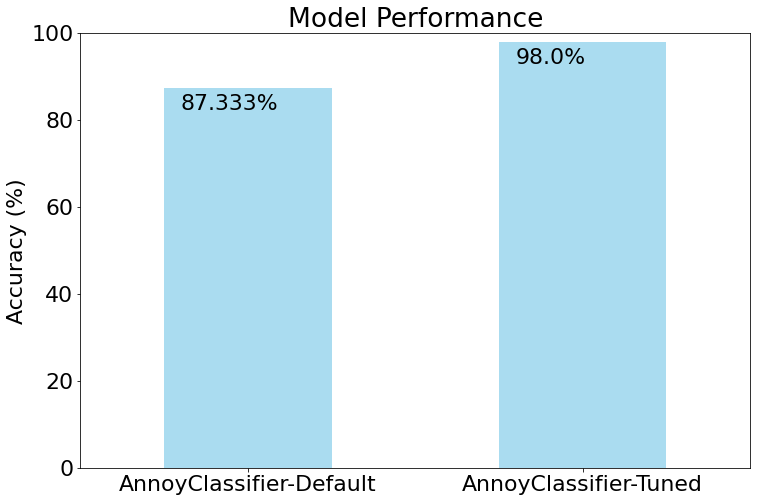

In [44]:
acc =  [acc_default*100,acc_tuned*100]
rows = ["AnnoyClassifier-Default", "AnnoyClassifier-Tuned"]

df = pd.DataFrame({"models": rows, "Accuracy":acc})

fig = plt.figure()
ax = df['Accuracy'].plot(kind="bar", figsize=(12, 8), alpha=0.7,
                 color=[
                     'skyblue'
                 ], label = "Accuracy")

ax.set_xticklabels(df['models'])
ax.set_ylabel("Accuracy (%)")

ax.set_ylim(0,100)

plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)
for i,a in enumerate(acc):
    ax.text(i-0.2,a-5,str(round(a,3))+"%")
plt.text
plt.title("Model Performance")
plt.show()